In [1]:
!unzip "/content/drive/My Drive/PlantVillage.zip"

Streaming output truncated to the last 5000 lines.
  inflating: PlantVillage/train/Tomato__Tomato_YellowLeaf__Curl_Virus/96cd3041-9e88-4796-9e9f-e2eda1ecff42___YLCV_GCREC 2290.JPG  
  inflating: PlantVillage/train/Tomato__Tomato_YellowLeaf__Curl_Virus/96d03f6d-5f9e-46ae-ba3b-ea0aa5a5b32d___YLCV_NREC 2833.JPG  
   creating: PlantVillage/validation/
   creating: PlantVillage/validation/Pepper__bell___Bacterial_spot/
  inflating: PlantVillage/validation/Pepper__bell___Bacterial_spot/006adb74-934f-448f-a14f-62181742127b___JR_B.Spot 3395.JPG  
  inflating: PlantVillage/validation/Pepper__bell___Bacterial_spot/00f2e69a-1e56-412d-8a79-fdce794a17e4___JR_B.Spot 3132.JPG  
  inflating: PlantVillage/validation/Pepper__bell___Bacterial_spot/01dfb88b-cd5a-420c-b163-51f5fe07b74d___JR_B.Spot 9091.JPG  
  inflating: PlantVillage/validation/Pepper__bell___Bacterial_spot/01ebc916-4793-40a3-b5e4-a32687e4fa3d___NREC_B.Spot 9125.JPG  
  inflating: PlantVillage/validation/Pepper__bell___Bacterial_spot/02baf

In [2]:
from keras.applications import MobileNet

# MobileNet was designed to work on 224 x 224 pixel input images sizes
img_rows, img_cols = 224, 224 

# Re-loads the MobileNet model without the top or FC layers
MobileNet = MobileNet(weights = 'imagenet', 
                 include_top = False, 
                 input_shape = (img_rows, img_cols, 3))

# Here we freeze the last 4 layers 
# Layers are set to trainable as True by default
for layer in MobileNet.layers:
    layer.trainable = False
    
# Let's print our layers 
for (i,layer) in enumerate(MobileNet.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

Using TensorFlow backend.


17227776/17225924 [==============================] - 1s 0us/step
0 InputLayer False
1 ZeroPadding2D False
2 Conv2D False
3 BatchNormalization False
4 ReLU False
5 DepthwiseConv2D False
6 BatchNormalization False
7 ReLU False
8 Conv2D False
9 BatchNormalization False
10 ReLU False
11 ZeroPadding2D False
12 DepthwiseConv2D False
13 BatchNormalization False
14 ReLU False
15 Conv2D False
16 BatchNormalization False
17 ReLU False
18 DepthwiseConv2D False
19 BatchNormalization False
20 ReLU False
21 Conv2D False
22 BatchNormalization False
23 ReLU False
24 ZeroPadding2D False
25 DepthwiseConv2D False
26 BatchNormalization False
27 ReLU False
28 Conv2D False
29 BatchNormalization False
30 ReLU False
31 DepthwiseConv2D False
32 BatchNormalization False
33 ReLU False
34 Conv2D False
35 BatchNormalization False
36 ReLU False
37 ZeroPadding2D False
38 DepthwiseConv2D False
39 BatchNormalization False
40 ReLU False
41 Conv2D False
42 BatchNormalization False
43 ReLU False
44 DepthwiseConv2D False


In [0]:
def addTopModelMobileNet(bottom_model, num_classes):
    """creates the top or head of the model that will be 
    placed ontop of the bottom layers"""

    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(512,activation='relu')(top_model)
    top_model = Dense(num_classes,activation='softmax')(top_model)
    return top_model

In [4]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model

# Set our class number to 15
num_classes = 15

FC_Head = addTopModelMobileNet(MobileNet, num_classes)

model = Model(inputs = MobileNet.input, outputs = FC_Head)

print(model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128 

In [5]:
from keras.preprocessing.image import ImageDataGenerator

train_data_dir = 'PlantVillage/train'
validation_data_dir = 'PlantVillage/validation'

# Let's use some data augmentaiton 
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=45,
      width_shift_range=0.3,
      height_shift_range=0.3,
      horizontal_flip=True,
      fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale=1./255)
 
# set our batch size (typically on most mid tier systems we'll use 16-32)
batch_size = 32
 
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')

Found 20638 images belonging to 15 classes.
Found 4981 images belonging to 15 classes.


In [6]:
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping

                     
checkpoint = ModelCheckpoint("plant_disease_mobileNet.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)

# we put our call backs into a callback list
callbacks = [earlystop, checkpoint]

# We use a very small learning rate 
model.compile(loss = 'categorical_crossentropy',
              optimizer = RMSprop(lr = 0.001),
              metrics = ['accuracy'])

# Enter the number of training and validation samples here
nb_train_samples = 20638
nb_validation_samples = 4981

# We only train 5 EPOCHS 
epochs = 5
batch_size = 32

history = model.fit_generator(
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size)

Epoch 1/5
644/644 [==============================] - 263s 408ms/step - loss: 0.9991 - accuracy: 0.6937 - val_loss: 2.8082 - val_accuracy: 0.3659

Epoch 00001: val_loss improved from inf to 2.80823, saving model to plant_disease_mobileNet.h5
Epoch 2/5
644/644 [==============================] - 256s 398ms/step - loss: 0.5758 - accuracy: 0.8246 - val_loss: 4.5793 - val_accuracy: 0.2819

Epoch 00002: val_loss did not improve from 2.80823
Epoch 3/5
644/644 [==============================] - 257s 398ms/step - loss: 0.5216 - accuracy: 0.8414 - val_loss: 2.0522 - val_accuracy: 0.6054

Epoch 00003: val_loss improved from 2.80823 to 2.05223, saving model to plant_disease_mobileNet.h5
Epoch 4/5
644/644 [==============================] - 257s 398ms/step - loss: 0.4648 - accuracy: 0.8613 - val_loss: 3.4923 - val_accuracy: 0.4605

Epoch 00004: val_loss did not improve from 2.05223
Epoch 5/5
644/644 [==============================] - 255s 396ms/step - loss: 0.4472 - accuracy: 0.8678 - val_loss: 3.708

In [0]:
from keras.models import load_model

classifier = load_model('plant_disease_mobileNet.h5')

In [16]:
import os
new_list=os.listdir("PlantVillage/train")
new_list.sort()
#print(new_list)

string_generated= ["[{}]".format(i) for i in range(15)]
#print(string_generated)
plant_disease_dict= dict(zip(string_generated,new_list))
print(plant_disease_dict)

{'[0]': 'Pepper__bell___Bacterial_spot', '[1]': 'Pepper__bell___healthy', '[2]': 'Potato___Early_blight', '[3]': 'Potato___Late_blight', '[4]': 'Potato___healthy', '[5]': 'Tomato_Bacterial_spot', '[6]': 'Tomato_Early_blight', '[7]': 'Tomato_Late_blight', '[8]': 'Tomato_Leaf_Mold', '[9]': 'Tomato_Septoria_leaf_spot', '[10]': 'Tomato_Spider_mites_Two_spotted_spider_mite', '[11]': 'Tomato__Target_Spot', '[12]': 'Tomato__Tomato_YellowLeaf__Curl_Virus', '[13]': 'Tomato__Tomato_mosaic_virus', '[14]': 'Tomato_healthy'}


In [0]:
actual_predictions =["Pepper Bell Bacterial Spot","Pepper Bell Healthy","Potato Early Blight",
                     "Potato Late Blight","Potato Healthy","Tomato Bacterial Spot","Tomato Early Blight",
                     "Tomato Late Blight","Tomato Leaf Mold","Tomato Septoria Leaf Spot","Tomato Spider Mites",
                     "Tomato Target Spot","Tomato Yellow Curl Virus","Tomato Mosaic Virus","Tomato Healthy"]

In [18]:
len(actual_predictions)

15

In [21]:
plant_disease_dict_n=dict(zip(new_list,actual_predictions))
print(plant_disease_dict_n)

{'Pepper__bell___Bacterial_spot': 'Pepper Bell Bacterial Spot', 'Pepper__bell___healthy': 'Pepper Bell Healthy', 'Potato___Early_blight': 'Potato Early Blight', 'Potato___Late_blight': 'Potato Late Blight', 'Potato___healthy': 'Potato Healthy', 'Tomato_Bacterial_spot': 'Tomato Bacterial Spot', 'Tomato_Early_blight': 'Tomato Early Blight', 'Tomato_Late_blight': 'Tomato Late Blight', 'Tomato_Leaf_Mold': 'Tomato Leaf Mold', 'Tomato_Septoria_leaf_spot': 'Tomato Septoria Leaf Spot', 'Tomato_Spider_mites_Two_spotted_spider_mite': 'Tomato Spider Mites', 'Tomato__Target_Spot': 'Tomato Target Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus': 'Tomato Yellow Curl Virus', 'Tomato__Tomato_mosaic_virus': 'Tomato Mosaic Virus', 'Tomato_healthy': 'Tomato Healthy'}


In [0]:
from google.colab.patches import cv2_imshow
def draw_test(name, pred, im):
    disease = plant_disease_dict[str(pred)]
    BLACK = [0,0,0]
    expanded_image = cv2.copyMakeBorder(im, 80, 0, 0, 100 ,cv2.BORDER_CONSTANT,value=BLACK)
    cv2.putText(expanded_image, disease, (20, 60) , cv2.FONT_HERSHEY_SIMPLEX,0.5, (0,0,255), 2)
    cv2_imshow(expanded_image)

In [0]:
def getRandomImage(path):
    """function loads a random images from a random folder in our test path """
    folders = list(filter(lambda x: os.path.isdir(os.path.join(path, x)), os.listdir(path)))
    random_directory = np.random.randint(0,len(folders))
    path_class = folders[random_directory]
    print("Class - " + plant_disease_dict_n[str(path_class)])
    file_path = path + path_class
    file_names = [f for f in listdir(file_path) if isfile(join(file_path, f))]
    random_file_index = np.random.randint(0,len(file_names))
    image_name = file_names[random_file_index]
    return cv2.imread(file_path+"/"+image_name)    


Class - Pepper Bell Healthy


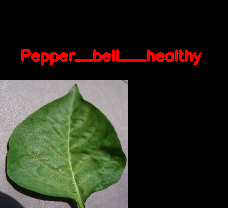

Class - Tomato Target Spot


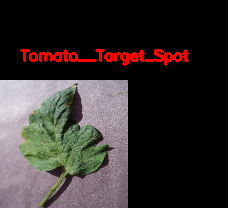

Class - Tomato Spider Mites


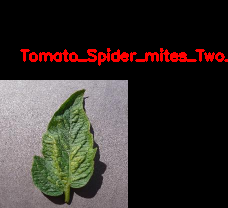

Class - Potato Early Blight


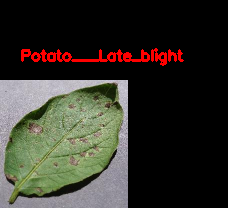

Class - Tomato Leaf Mold


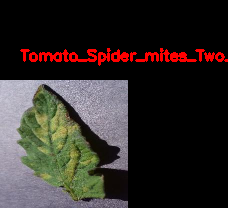

Class - Tomato Early Blight


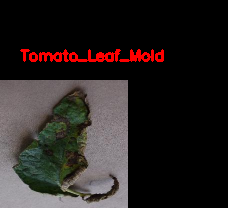

Class - Tomato Mosaic Virus


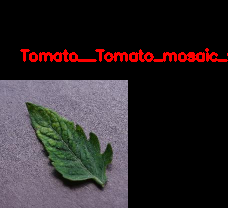

Class - Tomato Mosaic Virus


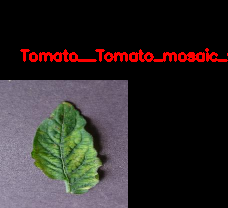

Class - Potato Healthy


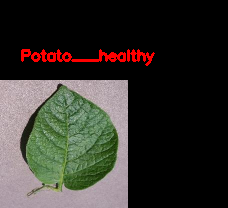

Class - Potato Healthy


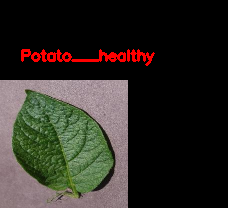

In [37]:
import os
import cv2
import numpy as np
from os import listdir
from os.path import isfile, join
from google.colab.patches import cv2_imshow
for i in range(0,10):
    input_im = getRandomImage("PlantVillage/train/")
    input_original = input_im.copy()
    input_original = cv2.resize(input_original, None, fx=0.5, fy=0.5, interpolation = cv2.INTER_LINEAR)
    
    input_im = cv2.resize(input_im, (224, 224), interpolation = cv2.INTER_LINEAR)
    input_im = input_im / 255.
    input_im = input_im.reshape(1,224,224,3) 
    
    # Get Prediction
    res = np.argmax(classifier.predict(input_im, 1, verbose = 0), axis=1)
    
    # Show image with predicted class
    draw_test("Prediction", res, input_original) 
    cv2.waitKey(0)
